In [160]:
import numpy as np
import pandas as pd

# Data loading and cleaning

In [161]:
# Loading data from raw_data
X_train = pd.read_csv('../../raw_data/clean_sentiment_data/X_train.csv')
y_train = pd.read_csv('../../raw_data/clean_sentiment_data/y_train.csv')
# X_test = pd.read_csv('../../raw_data/clean_sentiment_data/X_test.csv')
# y_test = pd.read_csv('../../raw_data/clean_sentiment_data/y_test.csv')

In [162]:
# Transforming y in pd.Series
y_train = y_train['Answer.sentiment']

# Binary classification

## Data cleaning

In [163]:
y_train_bin = y_train.apply(lambda x: 0 if x <= 0 else 1)

In [164]:
X_train.drop(columns=['Segment_ID', 'clip', 'ID'])

,Phrase
0,But (uhh) so yeah
1,The movie ruins it for itself
2,"(umm) The acting's subpar, the screen the scr..."
3,"And now, because of that, Machinima got intimi..."
4,I thought something would have to descend on m...
...,...
10837,"When we're talking about a verb, a verb can ha..."
10838,"If you are continuing at OSU, I hope you have ..."
10839,"I come in and I say ""Okay, hi everybody I'm go..."
10840,"This time, in the birthplace of modern innovat..."


## Basic preprocessing

### Lowercase

In [165]:
def lower(x):
    return x.lower()

In [166]:
X_train['clean_text'] = X_train['Phrase'].apply(lower)

### Remove punctuation

In [167]:
import string
def punct(x):
    for text in string.punctuation:
        x = x.replace(text, '')
    return x

In [168]:
X_train['clean_text'] = X_train['clean_text'].apply(punct)

### Remove numbers

In [169]:
def del_num(x):
    return ''.join([letter for letter in x if not letter.isdigit()])

In [170]:
X_train['clean_text'] = X_train['clean_text'].apply(del_num)

## First model with bag of words CountVectorizer & MultinomialNB

In [211]:
# Create a validation set on X_train
from sklearn.model_selection import train_test_split

X_t, X_val, y_t, y_val = train_test_split(X_train, y_train_bin, test_size=0.2)

In [212]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_t['clean_text'])
X_t_vect1 = vectorizer.transform(X_t['clean_text'])

In [213]:
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()

nb_model.fit(X_t_vect1, y_t)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [214]:
# Vectorizer on X_val
X_val_vect1 = vectorizer.transform(X_val['clean_text'])

In [215]:
# Compute accuracy on validation set
round(nb_model.score(X_val_vect1, y_val),2)

0.7

In [216]:
y_pred1 = nb_model.predict(X_val_vect1)

In [217]:
from sklearn.metrics import confusion_matrix

matrix1 = confusion_matrix(y_val, y_pred1)

<AxesSubplot:>

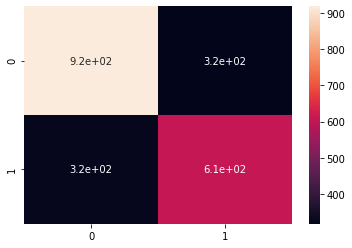

In [218]:
import seaborn as sns
sns.heatmap(matrix1, annot=True)

## Exploration of predicts from model 1

In [179]:
y_val_pred = nb_model.predict(X_val_vect1)

In [180]:
results = X_val.copy()

In [181]:
results['y_val'] = y_val

In [182]:
results['y_pred'] = y_val_pred

In [183]:
results = results.drop(columns=['clip', 'ID', 'Phrase'])

In [184]:
results['results'] = 1 - abs(results['y_val'] - results['y_pred'])

In [185]:
results.shape

(2169, 5)

In [186]:
tete_faux = results[results['results'] == 0 ]

In [187]:
tete_faux.to_csv('False_nlp_ml_m1.csv', index=False)

## Tf-Id vectorizer

In [125]:
# Creation of a pipeline a grid search to know which parameters are better 

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('vect', TfidfVectorizer()),
    ('model', MultinomialNB ())
])

grid_params = {'vect__max_df': [0.7, 0.8, 0.9],
              'vect__max_features': [30, 40, 50, 60],
              'vect__ngram_range': [(1,1), (2,2)],
              'vect__min_df': [0.8, 0.9, 1]}

search = GridSearchCV(pipe, grid_params, n_jobs=-1, verbose=1, scoring='accuracy',cv=5)

In [126]:
search.fit(X_t['clean_text'], y_t)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   54.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [127]:
search.best_params_

{'vect__max_df': 0.7,
 'vect__max_features': 50,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1)}

In [128]:
pipe_good = Pipeline([
    ('vect', TfidfVectorizer(max_df = 0.7, max_features = 50, ngram_range = (1,1))),
    ('model', MultinomialNB())
])

In [129]:
pipe_good.fit(X_t['clean_text'], y_t)

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.7, max_features=50,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('model',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [130]:
round(pipe_good.score(X_val['clean_text'], y_val),2)

0.65

<AxesSubplot:>

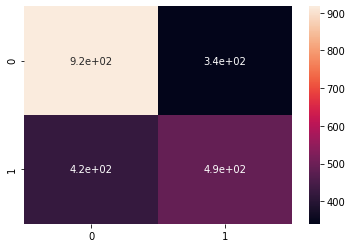

In [131]:
y_pred2 = pipe_good.predict(X_val['clean_text'])
matrix2 = confusion_matrix(y_val, y_pred2)
sns.heatmap(matrix2, annot=True)

## Test previous models with more preprocessing: stopwords + lemmising

### Remove stopwords

In [188]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def rem_stop(x):
    word_tokens = word_tokenize(x)
    return ' '.join([word for word in word_tokens if word not in stop_words])
X_train['clean_text2'] = X_train['clean_text'].apply(rem_stop)

In [189]:
X_train.head(10)

,Segment_ID,Phrase,clip,ID,clean_text,clean_text2
0,2453226,But (uhh) so yeah,6,245322,but uhh so yeah,uhh yeah
1,8879712,The movie ruins it for itself,12,88797,the movie ruins it for itself,movie ruins
2,1378276,"(umm) The acting's subpar, the screen the scr...",6,137827,umm the actings subpar the screen the screenp...,umm actings subpar screen screenplay stutter d...
3,3MFNIag0wNE9,"And now, because of that, Machinima got intimi...",9,3MFNIag0wNE,and now because of that machinima got intimida...,machinima got intimidated decided shut show en...
4,3sUS8vXbRwg14,I thought something would have to descend on m...,14,3sUS8vXbRwg,i thought something would have to descend on m...,thought something would descend would level pu...
5,fz-MzQcOBwQ12,I don't say this lightly but this is probably...,12,fz-MzQcOBwQ,i dont say this lightly but this is probably ...,dont say lightly probably one best books ever ...
6,1069412,"Surely, surely (stutter) wasn't hostile",2,106941,surely surely stutter wasnt hostile,surely surely stutter wasnt hostile
7,Kpe5fISxRTg6,Basically you're going to want to increase flu...,6,Kpe5fISxRTg,basically youre going to want to increase flui...,basically youre going want increase fluids res...
8,67uKYi7mslE14,That topic has come up before so that’s somet...,14,67uKYi7mslE,that topic has come up before so that’s somet...,topic come ’ something ’ looking maybe somethi...
9,18092311,I found this film to be one of the worst Disn...,11,180923,i found this film to be one of the worst disn...,found film one worst disney movies


### Lemmatizing

In [190]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize(x):
    a = x.split(' ')
    lemmatized = [lemmatizer.lemmatize(word) for word in a]
    return ' '.join(lemmatized)

In [191]:
X_train['clean_text2'] = X_train['clean_text2'].apply(lemmatize)

In [192]:
X_train.head(10)

,Segment_ID,Phrase,clip,ID,clean_text,clean_text2
0,2453226,But (uhh) so yeah,6,245322,but uhh so yeah,uhh yeah
1,8879712,The movie ruins it for itself,12,88797,the movie ruins it for itself,movie ruin
2,1378276,"(umm) The acting's subpar, the screen the scr...",6,137827,umm the actings subpar the screen the screenp...,umm acting subpar screen screenplay stutter di...
3,3MFNIag0wNE9,"And now, because of that, Machinima got intimi...",9,3MFNIag0wNE,and now because of that machinima got intimida...,machinima got intimidated decided shut show en...
4,3sUS8vXbRwg14,I thought something would have to descend on m...,14,3sUS8vXbRwg,i thought something would have to descend on m...,thought something would descend would level pu...
5,fz-MzQcOBwQ12,I don't say this lightly but this is probably...,12,fz-MzQcOBwQ,i dont say this lightly but this is probably ...,dont say lightly probably one best book ever read
6,1069412,"Surely, surely (stutter) wasn't hostile",2,106941,surely surely stutter wasnt hostile,surely surely stutter wasnt hostile
7,Kpe5fISxRTg6,Basically you're going to want to increase flu...,6,Kpe5fISxRTg,basically youre going to want to increase flui...,basically youre going want increase fluid rest...
8,67uKYi7mslE14,That topic has come up before so that’s somet...,14,67uKYi7mslE,that topic has come up before so that’s somet...,topic come ’ something ’ looking maybe somethi...
9,18092311,I found this film to be one of the worst Disn...,11,180923,i found this film to be one of the worst disn...,found film one worst disney movie


### Testing model on it

In [278]:
# Create a validation set on X_train
from sklearn.model_selection import train_test_split

X_t, X_val, y_t, y_val = train_test_split(X_train, y_train_bin, test_size=0.2)

In [279]:
vectorizer = CountVectorizer()
vectorizer.fit(X_t['clean_text2'])
X_t_vect2 = vectorizer.transform(X_t['clean_text2'])

In [280]:
nb_model2 = MultinomialNB()

nb_model2.fit(X_t_vect2, y_t)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [281]:
# Vectorizer on X_val
X_val_vect2 = vectorizer.transform(X_val['clean_text2'])

In [282]:
# Compute accuracy on validation set
round(nb_model2.score(X_val_vect2, y_val),2)

0.7

In [283]:
y_pred2 = nb_model2.predict(X_val_vect2)

In [284]:
matrix3 = confusion_matrix(y_val, y_pred2)

<AxesSubplot:>

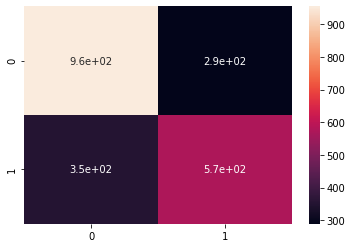

In [285]:
import seaborn as sns
sns.heatmap(matrix3, annot=True)

# 3-dim classification -0.5, 0.5

## Data cleaning

In [257]:
# Let's create 3 classes: -1 if neg, 0 if neutral, 1 if positive. We settle netral btw -0.5 & 0.5

def first_split(x):
    if x < -0.5:
        return -1
    if x < 0.5:
        return 0
    else:
        return 1

In [258]:
y_train_class3 = y_train.apply(first_split)

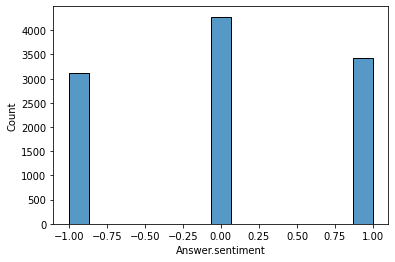

In [259]:
# Classes appear to be relatively balanced with this split
sns.histplot(y_train_class3);

## First model

In [260]:
X_train.head(1)

,Segment_ID,Phrase,clip,ID,clean_text,clean_text2
0,2453226,But (uhh) so yeah,6,245322,but uhh so yeah,uhh yeah


In [261]:
y_train_class3.head(1)

0    0
Name: Answer.sentiment, dtype: int64

In [286]:
# Create a validation set on X_train
from sklearn.model_selection import train_test_split

X_t, X_val, y_t, y_val = train_test_split(X_train, y_train_class3, test_size=0.2)

In [263]:
y_val.value_counts()

 0    825
 1    712
-1    632
Name: Answer.sentiment, dtype: int64

In [264]:
vectorizer = CountVectorizer()
vectorizer.fit(X_t['clean_text'])
X_t_vect3 = vectorizer.transform(X_t['clean_text'])

In [265]:
nb_model3 = MultinomialNB()
nb_model3.fit(X_t_vect3, y_t)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [266]:
X_val_vect3 = vectorizer.transform(X_val['clean_text'])

In [267]:
round(nb_model3.score(X_val_vect3, y_val),2)

0.59

In [268]:
y_pred3 = nb_model3.predict(X_val_vect3)

In [271]:
labels = [-1, 0, 1]

In [272]:
matrix3 = confusion_matrix(y_val, y_pred3, labels)

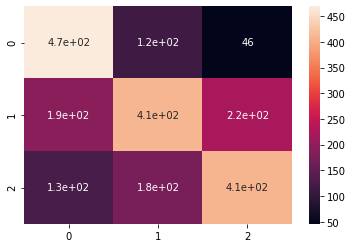

In [273]:
sns.heatmap(matrix3, annot=True);

In [255]:
y_pred3

array([0, 0, 0, ..., 1, 2, 0])

## CountVectorizer grid search

In [328]:
# Create a validation set on X_train
from sklearn.model_selection import train_test_split

X_t, X_val, y_t, y_val = train_test_split(X_train, y_train_class3, test_size=0.2)

In [379]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('model', MultinomialNB ())
])

grid_params = {'vect__max_df': [0.4, 0.5],
              'vect__max_features': [9000, 10000, 11000]}

search = GridSearchCV(pipe, grid_params, n_jobs=-1, verbose=1, scoring='accuracy',cv=5)

In [380]:
search.fit(X_t['clean_text'], y_t)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [381]:
search.best_params_

{'vect__max_df': 0.5, 'vect__max_features': 10000}

In [382]:
pipe_good = Pipeline([
    ('vect', TfidfVectorizer(max_df = 0.5, max_features = 10000, min_df= 1)),
    ('model', MultinomialNB())
])

In [383]:
pipe_good.fit(X_t['clean_text'], y_t)

Pipeline(memory=None,
         steps=[('vect',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=10000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('model',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [384]:
round(pipe_good.score(X_val['clean_text'], y_val),2)

0.61

## With more processing

In [287]:
# Create a validation set on X_train
from sklearn.model_selection import train_test_split

X_t, X_val, y_t, y_val = train_test_split(X_train, y_train_class3, test_size=0.2)

In [288]:
vectorizer = CountVectorizer()
vectorizer.fit(X_t['clean_text2'])
X_t_vect2 = vectorizer.transform(X_t['clean_text2'])

In [289]:
nb_model4 = MultinomialNB()

nb_model4.fit(X_t_vect2, y_t)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [290]:
X_val_vect4 = vectorizer.transform(X_val['clean_text2'])

In [292]:
round(nb_model4.score(X_val_vect4, y_val),2)

0.58

In [293]:
y_pred4 = nb_model4.predict(X_val_vect4)

In [294]:
matrix4 = confusion_matrix(y_val, y_pred4)

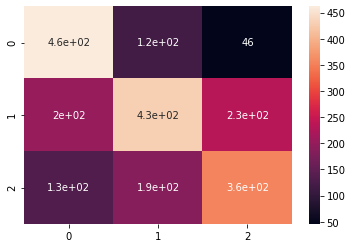

In [295]:
sns.heatmap(matrix4, annot=True);

In [307]:
import nltk

In [303]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

In [311]:
nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/corentin/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


True

In [324]:
wiki = TextBlob("I am in love", analyzer=NaiveBayesAnalyzer())

In [325]:
wiki.sentiment.p_pos

0.5441400304414004

In [319]:
def text_blob(x):
    return TextBlob(x, analyzer=NaiveBayesAnalyzer()).sentiment.p_pos

In [322]:
X_train.head()

,Segment_ID,Phrase,clip,ID,clean_text,clean_text2,textblob
0,2453226,But (uhh) so yeah,6,245322,but uhh so yeah,uhh yeah,
1,8879712,The movie ruins it for itself,12,88797,the movie ruins it for itself,movie ruin,
2,1378276,"(umm) The acting's subpar, the screen the scr...",6,137827,umm the actings subpar the screen the screenp...,umm acting subpar screen screenplay stutter di...,
3,3MFNIag0wNE9,"And now, because of that, Machinima got intimi...",9,3MFNIag0wNE,and now because of that machinima got intimida...,machinima got intimidated decided shut show en...,
4,3sUS8vXbRwg14,I thought something would have to descend on m...,14,3sUS8vXbRwg,i thought something would have to descend on m...,thought something would descend would level pu...,


In [ ]:
X_train_sample= X_train.sample()

In [ ]:
def fun_textblob(x):
    return 1 if x > 0.5 else 0

In [ ]:
blob_pred = X_train['textblob'].apply(fun_textblob)

# 3-dim -1 1

## Data cleaning

In [385]:
# Let's create 3 classes: -1 if neg, 0 if neutral, 1 if positive. We settle netral btw -1 & 1

def first_split(x):
    if x < -1:
        return -1
    if x < 1:
        return 0
    else:
        return 1

In [386]:
y_train_class3_bis = y_train.apply(first_split)

In [403]:
X_train = X_train.drop(columns=['y'])

In [405]:
X_train = X_train.drop(columns=['textblob'])

In [406]:
df = X_train.copy()
df['y'] = y_train_class3_bis

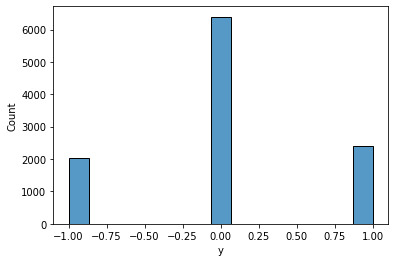

In [407]:
# Classes appear to be relatively balanced with this split
sns.histplot(df['y']);

In [409]:
df_majority = df[df['y'] == 0]
df_minority = df[df['y'] != 0]

In [410]:
from sklearn.utils import resample

df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=2500) # reproducible results

In [411]:
df_majority_downsampled.shape

(2500, 7)

In [412]:
df_minority.shape

(4447, 7)

In [413]:
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [414]:
df_downsampled.shape

(6947, 7)

In [415]:
X_bal = df_downsampled.drop(columns=['y'])
y_bal = df_downsampled['y']

In [416]:
X_t_bal, X_val_bal, y_t_bal, y_val_bal = train_test_split(X_bal, y_bal, test_size=.2)

In [420]:
y_t_bal.value_counts()

 0    1993
 1    1902
-1    1662
Name: y, dtype: int64

In [421]:
vectorizer = CountVectorizer()
vectorizer.fit(X_t_bal['clean_text'])
X_t_vect5 = vectorizer.transform(X_t_bal['clean_text'])

In [422]:
nb_model5 = MultinomialNB()
nb_model5.fit(X_t_vect5, y_t_bal)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [423]:
X_val_vect5 = vectorizer.transform(X_val_bal['clean_text'])

In [424]:
round(nb_model5.score(X_val_vect5, y_val_bal),2)

0.61

In [426]:
y_pred5 = nb_model5.predict(X_val_vect5)

In [427]:
matrix5 = confusion_matrix(y_val_bal, y_pred5)

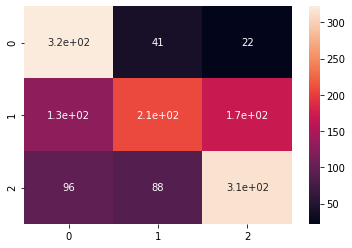

In [428]:
sns.heatmap(matrix5, annot=True);

In [429]:
df_downsampled.shape, y_pred5.shape

((6947, 7), (1390,))

In [430]:
X_val_bal.shape

(1390, 6)

In [431]:
X_val_bal.head(3)

,Segment_ID,Phrase,clip,ID,clean_text,clean_text2
1776,734494,Independence Day and Godzilla this movie is not,4,73449,independence day and godzilla this movie is not,independence day godzilla movie
7675,27062825,"So even though it, the music dragged you down...",25,270628,so even though it the music dragged you down ...,even though music dragged sad part movie bring...
10091,24418019,And they did pretty good special effects with...,19,244180,and they did pretty good special effects with...,pretty good special effect demon thing like


In [434]:
results2 = X_val_bal.copy()
results2['y'] = y_val_bal

In [435]:
results2['y_pred'] = y_pred5

In [436]:
results2.head()

,Segment_ID,Phrase,clip,ID,clean_text,clean_text2,y,y_pred
1776,734494,Independence Day and Godzilla this movie is not,4,73449,independence day and godzilla this movie is not,independence day godzilla movie,-1,-1
7675,27062825,"So even though it, the music dragged you down...",25,270628,so even though it the music dragged you down ...,even though music dragged sad part movie bring...,-1,-1
10091,24418019,And they did pretty good special effects with...,19,244180,and they did pretty good special effects with...,pretty good special effect demon thing like,1,-1
8047,G38DwNDQ8Cc7,"Imagine that you mulled this over, and time af...",7,G38DwNDQ8Cc,imagine that you mulled this over and time aft...,imagine mulled time time said nothing filled c...,0,0
10177,360987,"The graphics are bad and everything, the acting",7,36098,the graphics are bad and everything the acting,graphic bad everything acting,-1,-1


In [445]:
results2["confusion"] = abs(results2["y"] - results2["y_pred"])

In [446]:
results2.head()

,Segment_ID,Phrase,clip,ID,clean_text,clean_text2,y,y_pred,confusion
1776,734494,Independence Day and Godzilla this movie is not,4,73449,independence day and godzilla this movie is not,independence day godzilla movie,-1,-1,0
7675,27062825,"So even though it, the music dragged you down...",25,270628,so even though it the music dragged you down ...,even though music dragged sad part movie bring...,-1,-1,0
10091,24418019,And they did pretty good special effects with...,19,244180,and they did pretty good special effects with...,pretty good special effect demon thing like,1,-1,2
8047,G38DwNDQ8Cc7,"Imagine that you mulled this over, and time af...",7,G38DwNDQ8Cc,imagine that you mulled this over and time aft...,imagine mulled time time said nothing filled c...,0,0,0
10177,360987,"The graphics are bad and everything, the acting",7,36098,the graphics are bad and everything the acting,graphic bad everything acting,-1,-1,0


In [449]:
results_wrong = results2[results2['confusion'] == 1]

In [450]:
results_wrong.shape

(428, 9)

In [454]:
sample_wrong = results_wrong.sample(n=20)

In [453]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

blob = TextBlob("I love this library", analyzer=NaiveBayesAnalyzer())
blob.sentiment.p_pos

0.7996209910191279

In [460]:
def blob(x):
    blob = TextBlob(x, analyzer=NaiveBayesAnalyzer())
    if blob.sentiment.p_pos < 0.4:
        return -1
    elif blob.sentiment.p_pos < 0.6:
        return 0
    else:
        return 1

In [461]:
sample_wrong['blob'] = sample_wrong['Phrase'].apply(blob)

In [462]:
sample_wrong.head(10)

,Segment_ID,Phrase,clip,ID,clean_text,clean_text2,y,y_pred,confusion,blob
902,2340539,We have some special features here,9,234053,we have some special features here,special feature,0,1,1,0
7980,K62NK2KYhws14,I also share insights from campaigns I’ve over...,14,K62NK2KYhws,i also share insights from campaigns i’ve over...,also share insight campaign ’ overseen usp res...,0,1,1,1
1812,MoQmPA7Q07Q4,Yet at the same point I'm watching them strug...,4,MoQmPA7Q07Q,yet at the same point im watching them strugg...,yet point im watching struggle financially fun...,-1,0,1,1
6030,Bg-PA5KTjNs7,I followed the instructions closely and after ...,7,Bg-PA5KTjNs,i followed the instructions closely and after ...,followed instruction closely week hair loss ac...,1,0,1,1
6647,4iG0ffmnCOw7,"Beyond that, I actually excelled academically ...",7,4iG0ffmnCOw,beyond that i actually excelled academically f...,beyond actually excelled academically decision,0,1,1,0
5177,CO2YoTZbUr08,So now you're at the table with the light over...,8,CO2YoTZbUr0,so now youre at the table with the light over ...,youre table light theyre asking question saw m...,0,1,1,1
2937,ZtocGyL3Tfc10,The ILO has highlighted that there is a link b...,10,ZtocGyL3Tfc,the ilo has highlighted that there is a link b...,ilo highlighted link social justice fair globa...,1,0,1,1
5035,2340537,""" Those are noble words about a movie right there",7,234053,those are noble words about a movie right there,noble word movie right,1,0,1,0
7627,PQYmOknHA4c11,I don't mean your city,11,PQYmOknHA4c,i dont mean your city,dont mean city,1,0,1,0
8278,4026013,"So he does, he runs for president and he actu...",13,40260,so he does he runs for president and he actua...,run president actually get stutter voting system,1,0,1,-1
